# Hypervector algorithms for simultaneous one-shot learning and generalization

Inspired by the work of Rumelhart and McCleland, we developed a neural network system for solving the challenge of learning the rules that govern the transformation of present-tense verbs to past-tense. 

We utilize hypercomputing to formalize the algorithm that they proposed, including how to represent "Wickelfeatures" and use a neural network to learn the transformation from the present-tense Wickelfeature representation to the past-tense. 

With advances in hypercomputing theory, we are able to go beyond the previous work and achieve three notable goals: 
 1. Perform one-shot learning on the training set. 
 2. Create a system that can also generalize to words in the test set. 
 3. Infer the letter sequence of the word from the Wickelfeature representation.
 
Goal 3 presents a fundamental challenge of performing a combinatoric search, and was a desired aspect of the original work but never realized. Because it is such a challenge to infer the word from the Wickelfeature representation, validation of the learning in goals 1/2 is difficult. To validate the performance of their original network, Rumelhart and McCleland examined the similarity of the abstract high-level Wickelfeature representations of the network's output to the correct words representation. Although this is indirect, comparison in the abstract feature space is still useful to understand the network's performance. 

In this section, we compare several variations of a hypercomputing algorithm that can perform one-shot learning of the present to past transformation. We use the abstract representation of Wickelfeatures to represent each word in this generalizable abstract feature space, and use the binding mechanism to create a content-addressable dictionary of present-tense to past-tense words. By representing the words in a generalizable feature space, we are really creating a dictionary of word parts and mapping common present-tense word parts to common past-tense word parts. This potentially allows the dictionary to highlight common mappings between word parts, and can enable generalization of the transformation to novel verbs. 



In [32]:
from __future__ import division

from pylab import *
import scipy
import time

import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF

import utils
import hrr_utils

import string

from scipy import spatial
from matplotlib.collections import LineCollection
%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [33]:
N=10000

In [34]:
alphabet = string.ascii_lowercase + "#."

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.' 
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1



def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = ngram_encode_cl(pair[1], dic1, 3)
        past2 = ngram_encode_cl(pair[1], dic2, 3)
        pres1 = ngram_encode_cl(pair[0], dic1, 3)
        pres2 = ngram_encode_cl(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def train(tv, past, present):
    tv += np.multiply(past, present)
    return tv

def reg_train(tv, past, present):
    pred = np.multiply(tv, present)
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past))/float(N)) * np.multiply(past, present)
    return tv

def pcaw_train(past, present, num_pc=20):
    pp_pair = np.multiply(past, present)
    tst = time.time()
    pp_u, pp_s, pp_v = np.linalg.svd(pp_pair)
    #print 'Elapsed: ', time.time() - tst
    
    cidx = min(num_pc, pp_u.shape[1])
    return np.dot(pp_u[:, :cidx], pp_v[:cidx, :]).sum(axis=0)

def regression_train(past, present):
    w = np.linalg.lstsq(present, past, rcond=5e-2)[0]
    return w

def train_diff(tv, past2, present1, present2):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    #pred = np.where(pred>0, 1, -1)
    #print (sim(pred, past)),
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv


def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, y3, title=None):

    fig = plt.figure()
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    plt.plot(x, y3, label="random")
    fig.suptitle(title, fontsize=20)
    plt.xlabel('number of words', fontsize=18)
    plt.ylabel('average dot product', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()
    #fig.savefig('test.jpg')
    
def graphstd(x, y1, y2, y1std, y2std, ylims=[], title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
 
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])
    plt.ylim(ylims)

    plt.tight_layout()

In [35]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]


#dic1 = hrr_utils.GenerateDefaultDictionary(N)
#dic2 = hrr_utils.GenerateDefaultDictionary(N)

D = len(alphabet)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

regular.extend(irregular)
verbs = regular

In [36]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

In [37]:
k=100

In [38]:
tst = time.time()
w_regress = regression_train(trainpast2[:k], trainpres1[:k])
print 'Elapsed:', time.time() - tst

Elapsed: 13.758646965


In [39]:
w_regress[0].shape

(10000,)

In [40]:
psi_pca = pcaw_train(trainpast2[:k], trainpres1[:k])

In [41]:
psi = np.zeros(N)
psi_r = np.zeros(N)
for i in range(k):
    psi = train(psi, trainpast2[i], trainpres1[i])
    psi_r = reg_train(psi_r, trainpast2[i], trainpres1[i])


(400, 600)

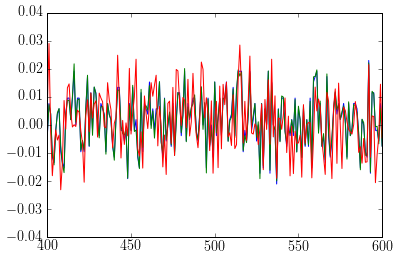

In [42]:
plot(psi / norm(psi))
plot(psi_r / norm(psi_r))
plot(psi_pca / norm(psi_pca))
xlim([400, 600])

## Trigram dictionary, unregularized

In this section, we begin with the simplest algorithm that forms a content-addressable dictionary by binding present-tense verbs to past-tense verbs and holding the superposition of all verbs in the training set in memory. 

In [ ]:
tst = time.time()

psi = np.zeros(N)
psi = train(psi, trainpast2[0], trainpres1[0])

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


y1 = np.zeros(trainpres1.shape[0])
y2 = np.zeros(trainpres1.shape[0])
y3 = np.zeros(trainpres1.shape[0])
for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = train(psi, trainpast2[k], trainpres1[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/quinntran/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


figures/pp_trigram_dict_pca_170309-trigram_dict-unreg-N=1000-W=1889-170428


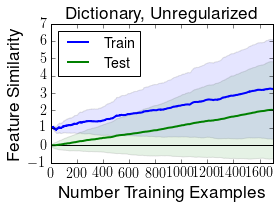

In [13]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper left',fontsize=12)

xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Dictionary, Unregularized',fontsize=16)

xlim([0, 1700])
ylim([-3,7])
tight_layout()

fname =  ('figures/pp_trigram_dict_pca_170309-trigram_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

**Figure 1. Wickelfeature dictionary.** We evaluated the performance of the network by comparing the network's output to the Wickelfeature representation of the correct word. We see that all words in the training set have high similarity (blue line), but also that the similarity increases beyond the normal level. We also see that as more verb pairs are encountered that words in the test set also increase in similarity to the correct answer in the feature space. 

This algorithm can be seen to generalize to the test set, but it is challenging to interpret its performance purely in the abstract feature space. We see that the training set similarity increases beyond the normal value, which indicates that the network is over-emphasizing some aspects of the transformation. Essentially, this increase beyond $N$ in similarity is due to the same force that allows the network to generalize to novel verbs. As more verb pairs are added to the dictionary, then the common transformations start to stand out and get emphasized. The verbs in the training set all contribute to the similarity of the output, and many of them are contributing the same thing -- namely the regular rule of adding the trigram "ed." to create the past tense verbs. This explains the similarity going above $N$, as many verb-pairs are shouting the same correct feature. 


## Trigram dictionary, regularized

In the previous section, we see that a straight-forward dictionary created by hypercomputing binding results in over-emphasis of the common rule. Because we expect the representation of the dictionary elements to be generalizable, then there should be some common correlations that the features will emphasize. However, such a dictionary may drown-out other important aspects of the transformation to emphasize the common rule in the training data. The performance of the algorithm above can be explained by the system always emphasizing the most common transformation of adding "ed.". 

Next, we use a regularization procedure akin to perceptron learning or gradient descent for which we evaluate the error of a new word in the training set prior to adding it to the dictionary. By checking first to see how much other words in the training set already explain the transformation described by the new verb-pair, we can create a system that will not simply be dominated by the most common transformation. Further, the verbs in the training set will not continuously increase beyond the natural limit for the similarity in the feature space, and thus the most common transformation will not be over-emphasized.



In [14]:
tst = time.time()

cycle=1
psi = np.zeros(N)
psi = reg_train(psi, trainpast2[0], trainpres1[0])

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = reg_train(psi, trainpast2[k], trainpres1[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)

Elapsed:  55.7897469997
data/pp_trigram_dict_pca_170309-trigram_dict-reg-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_dict-reg-N=1000-W=1889-170428


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


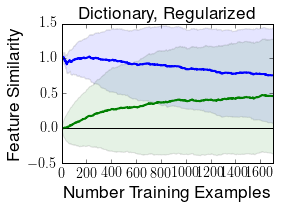

In [15]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)

    
train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='lower right',fontsize=12)
xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Dictionary, Regularized',fontsize=16)

xlim([0, 1700])

plt.tight_layout()

fname =  ('figures/pp_trigram_dict_pca_170309-trigram_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

** Figure 2. Wickelfeature dictionary with regularization. ** We evaluate the network's performance by comparing the output to the correct answer and measuring the similarity in the feature space. We see that words in the training set start with high similarity and remain high (blue), indicating one-shot learning. Words in the test set increase as more words are added in the training set and common transformations are found and applied. 

With this regularization rule, we now can see a network that describes the training set words accurately and can perform one-shot learning and still there is generalization to the test set. 

This regularized form of the algorithm can also iterate through the training data more than once. If we show it all of the training words a second time, we can improve its performance.

In [16]:
tst = time.time()

#psi = np.zeros(N)
cycle+=1

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist_c = np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist_c = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(len(trainpres1)):#trainpres1.shape[0]):
    psi = reg_train(psi, trainpast2[k], trainpres1[k])
    
    train_pred = np.multiply(psi, trainpres1)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist_c[k, :] = sim(train_pred, trainpast2)
    test_hist_c[k, :] = sim(test_pred, testpast2)
    

    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_dict-reg-cycle=' + str(cycle) + '-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist_c=train_hist_c, test_hist_c=test_hist_c)

Elapsed:  74.3082611561
data/pp_trigram_dict_pca_170309-trigram_dict-reg-cycle=2-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_dict-reg-cycle=2-N=1000-W=1889-170428


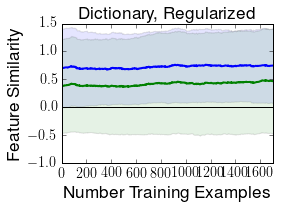

In [17]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)

train_mean = np.mean(train_hist_c, axis=1)/N
test_mean = test_hist_c.mean(axis=1)/N

train_std = np.std(train_hist_c, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist_c.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

#plot(ntrain_x, train_hist, lw=0.2, label='Train')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)
legend(loc='lower right',fontsize=12)
xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Dictionary, Regularized',fontsize=16)

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_dict-reg-cycle=' + str(cycle) +'-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

** Figure 3. Regularized dictionary cycle 2. ** We see that another cycle of the learning algorith through the training set begins to decrease the similarity, but this is because it was over-emphasized at the end of the first cycle. The error of the training set decreases after the second cycle. The test set performance slightly drops through the second cycle, but stays around the same level. The test set error is slightly lower, but it is hard to tell if this improved generalization performance. 

Further cycles through the training data can solidify the verb pairs in the training set in the dictionary. This could also be helpful for generalization, but it is hard to tell if performance in the test set improved with the second cycle.


## Trigram dictionary, pca 

In [18]:
tst = time.time()

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))

k_samps =range(2, len(trainpres1), 20)

for k in k_samps:#trainpres1.shape[0]):
    psi = pcaw_train(trainpast2[:k], trainpres1[:k])

    train_pred = np.multiply(psi, trainpres1[:k])
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_dict-pcaw-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist)

Elapsed:  180.079246044
data/pp_trigram_dict_pca_170309-trigram_dict-pcaw-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_dict-pcaw-N=1000-W=1889-170428


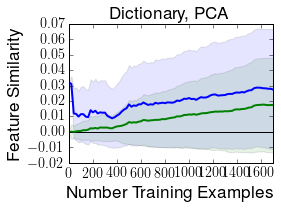

In [19]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
    
train_mean = np.nanmean(train_hist[k_samps, :], axis=1)/N
test_mean = test_hist[k_samps].mean(axis=1)/N

train_std = np.nanstd(train_hist[k_samps, :], axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist[k_samps, :].std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(trainpres1))+1
ntrain_x = ntrain_x[k_samps]

plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='upper left',fontsize=12)
xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Dictionary, PCA',fontsize=16)

xlim([0, 1700])


plt.tight_layout()

fname =  ('figures/pp_trigram_dict_pca_170309-trigram_dict-pcaw-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

## Regression


In [20]:
tst = time.time()

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))

k_samps =range(2, len(trainpres1), 20)

for k in k_samps:#trainpres1.shape[0]):
    psi_w = regression_train(trainpast2[:k], trainpres1[:k])

    train_pred = np.dot(trainpres1[:k], psi_w)
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.dot(testpres1, psi_w)
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_dict-regression-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist)

Elapsed:  357.093651056
data/pp_trigram_dict_pca_170309-trigram_dict-regression-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_dict-regression-N=1000-W=1889-170428


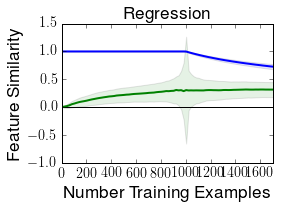

In [21]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
    
train_mean = np.nanmean(train_hist[k_samps, :], axis=1)/N
test_mean = test_hist[k_samps].mean(axis=1)/N

train_std = np.nanstd(train_hist[k_samps, :], axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist[k_samps, :].std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(trainpres1))+1
ntrain_x = ntrain_x[k_samps]

plot([0, 1700], [0, 0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc="lower right",fontsize=12)

xlabel('Number Training Examples',fontsize=16))
ylabel('Feature Similarity',fontsize=16))
title('Regression',fontsize=16))

xlim([0, 1700])

plt.tight_layout()

fname =  ('figures/pp_trigram_dict_pca_170309-trigram_dict-regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

## Trigram difference dictionary, unregularized

The algorithm we have described so far is a mapping of Wickelfeatures from the present tense verbs to the past tense verbs, however this mapping is not necessarily the best algorithm. One of the challenges with the mapping is that most present-past verb pairs have the same beginning letters. To get the correct output, we have to have the beginning of every present-tense word mapped to its same beginning for every past-tense word. This would require a lot more examples than are present in the training set. 

A more intuitive version of the algorithm is not to find a mapping, but rather a transformation. A transformation is described by taking the difference between the past-tense verb and the present-tense verb. Rather than storing a dictionary between all present-tense Wickelfeatures to all past-tense Wickelfeatures, we store a dictionary of all present-tense Wickelfeatures to all present-to-past transforms. We compute the transform simply as the difference between the past-tense word and the present-tense word in the feature space. Then to transform a present tense word to a past tense word, we look up the transformation from the dictionary and add it to the present tense word.

We first start by again making a naive dictionary that stores the transforms for each word in the training set with no regularization.



In [22]:
tst = time.time()

psi = np.zeros(N)
psi = train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])

# shouldn't this be {+1, -1}?
#random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
#random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    #random_hist[k, :] = sim(test_pred, random_vecs)
    
    psi = train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_difference_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
#np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist)

Elapsed:  84.1057531834
data/pp_trigram_dict_pca_170309-trigram_difference_dict-unreg-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_diff_dict-unreg-N=1000-W=1889-170428


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


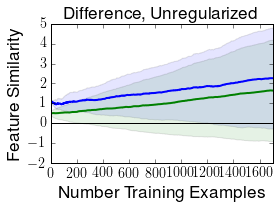

In [23]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)

train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N
#random_mean = random_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5
#random_std = random_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1
plot([0, 1700], [0,0], 'k')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)
legend(loc='upper left',fontsize=12)
xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Difference, Unregularized',fontsize=16)

xlim([0, 1700])

plt.tight_layout()

fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-unreg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

** Figure 4. Wickelfeature difference dictionary. ** The algorithm that stores the transform immediately has some similarity with words in the test set, because the present-tense word is usually similar to the past-tense word without any transformation. We again see the over-emphasis of certain transformation features, leading to similarities going above $N$. 

We see that the difference algorithm immediately has similarity for verb-pairs in the test set, and this occurs because this algorithm by default repeats the present-tense verb as the output. Since the present-tense verb is often similar to the past-tense verb, the network outputs similar verbs without any training. 

## Trigram difference dictionary, regularized

Finally, we use the difference algorithm with the regularization procedure as the algorithm.


In [24]:
tst = time.time()
cycle = 1
psi = np.zeros(N)
psi = reg_train_diff(psi, trainpast2[0], trainpres1[0], trainpres2[0])

#random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist = np.nan* np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))
#random_hist = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(1,len(trainpres1)):#trainpres1.shape[0]):
    train_pred = np.multiply(psi, trainpres1[:k]) + trainpres2[:k]
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist[k, :k] = sim(train_pred, trainpast2[:k])
    test_hist[k, :] = sim(test_pred, testpast2)
    #random_hist[k, :] = sim(random_vecs, testpast2)
    
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])

    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_difference_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
#np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist, random_hist=random_hist)
np.savez(fname,N=N, train_hist=train_hist, test_hist=test_hist)

Elapsed:  81.9025728703
data/pp_trigram_dict_pca_170309-trigram_difference_dict-reg-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=1000-W=1889-170428


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


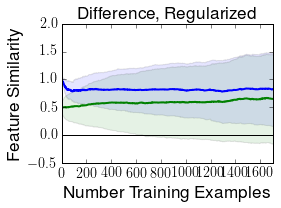

In [25]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
    
train_mean = np.nanmean(train_hist, axis=1)/N
test_mean = test_hist.mean(axis=1)/N

train_std = np.nanstd(train_hist, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

#plot(ntrain_x, train_hist, lw=0.2, label='Train')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)

legend(loc='lower right',fontsize=12)
xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Difference, Regularized',fontsize=16)

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

** Figure 5. Wickelfeature difference dictionary with regularization. ** We use the difference algorithm with regularization and see that words in the training set have high similarity throughout. Words in the test set start off with some similarity and increase.



figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=1000-W=1889-170428


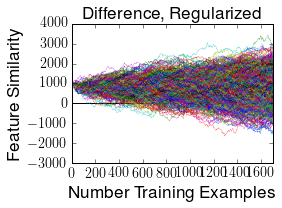

In [26]:
figure(figsize=(4,3))

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

plot(ntrain_x, train_hist, lw=0.2, label='Train')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

#plt.savefig(fname + '.png', transparent=True)
#plt.savefig(fname + '.eps', transparent=True)

figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=1000-W=1889-170428


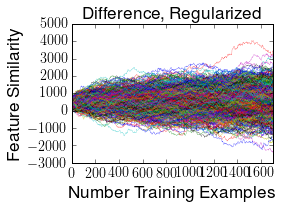

In [27]:
figure(figsize=(4,3))

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

plot(ntrain_x, test_hist, lw=0.2, label='Train')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

#plt.savefig(fname + '.png', transparent=True)
#plt.savefig(fname + '.eps', transparent=True)

In [28]:
tst = time.time()

#psi = np.zeros(N)
cycle+=1

random_vecs = np.random.randn(testpast2.shape[0], N)

train_hist_c = np.zeros((trainpres1.shape[0], trainpres1.shape[0]))
test_hist_c = np.zeros((trainpres1.shape[0], testpast2.shape[0]))


for k in range(len(trainpres1)):#trainpres1.shape[0]):
    psi = reg_train_diff(psi, trainpast2[k], trainpres1[k], trainpres2[k])
    
    train_pred = np.multiply(psi, trainpres1) + trainpres2
    #train_pred = np.where(train_pred>0, 1, -1)
    test_pred = np.multiply(psi, testpres1) + testpres2
    #test_pred = np.where(test_pred>0, 1, -1)

    train_hist_c[k, :] = sim(train_pred, trainpast2)
    test_hist_c[k, :] = sim(test_pred, testpast2)
    

    
print 'Elapsed: ', time.time() - tst

fname = ('data/pp_trigram_dict_pca_170309-trigram_difference_dict-reg-cycle=' + str(cycle) + '-N=' + str(N) + '-W=' + str(len(trainpres1))
        + '-' + time.strftime('%y%m%d') +'.npz')

print fname
np.savez(fname,N=N, train_hist_c=train_hist_c, test_hist_c=test_hist_c)

Elapsed:  110.657320023
data/pp_trigram_dict_pca_170309-trigram_difference_dict-reg-cycle=2-N=1000-W=1889-170428.npz


figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-cycle=2-N=1000-W=1889-170428


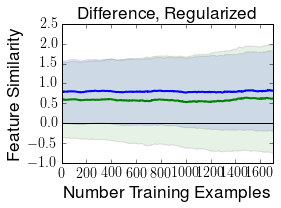

In [29]:
figure(figsize=(4,3))
tick_params(axis='both', which='major', labelsize=12)
tick_params(axis='both', which='minor', labelsize=12)
    
train_mean = np.mean(train_hist_c, axis=1)/N
test_mean = test_hist_c.mean(axis=1)/N

train_std = np.std(train_hist_c, axis=1)/N #/ (arange(len(train_mean))+1) ** 0.5
test_std = test_hist_c.std(axis=1)/N #/ testpast2.shape[0]**0.5

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

#plot(ntrain_x, train_hist, lw=0.2, label='Train')

plot(ntrain_x, train_mean, c='b', lw=2, label='Train')
plot(ntrain_x, test_mean, c='g', lw=2, label='Test')
#plot(ntrain_x, random_mean, c='r', lw=2, label='Random')

fill_between(ntrain_x, train_mean-train_std, train_mean+train_std, facecolor='b', alpha=0.1)
fill_between(ntrain_x, test_mean-test_std, test_mean+test_std, facecolor='g', alpha=0.1)
#fill_between(ntrain_x, random_mean-random_std, random_mean+random_std, facecolor='r', alpha=0.2)
legend(loc='lower right',fontsize=12)
xlabel('Number Training Examples',fontsize=16)
ylabel('Feature Similarity',fontsize=16)
title('Difference, Regularized',fontsize=16)

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-cycle=' + str(cycle) +'-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

** Figure 6. Second cycle of Wickelfeature difference dictionary with regularization. ** We again see some improvement in the variance of the training set, but it is hard to tell if there is improvement with test set generalization. 

figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=1000-W=1889-170428


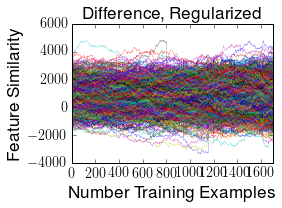

In [30]:
figure(figsize=(4,3))

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

plot(ntrain_x, train_hist_c, lw=0.2, label='Train')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

#plt.savefig(fname + '.png', transparent=True)
#plt.savefig(fname + '.eps', transparent=True)

figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=1000-W=1889-170428


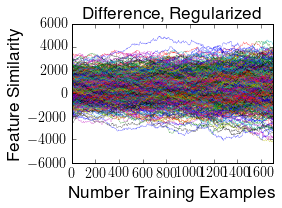

In [31]:
figure(figsize=(4,3))

ntrain_x = arange(len(train_mean))+1

plot([0, 1700], [0,0], 'k')

plot(ntrain_x, test_hist_c, lw=0.2, label='Train')

xlabel('Number Training Examples')
ylabel('Feature Similarity')
title('Difference, Regularized')

xlim([0, 1700])

plt.tight_layout()



fname =  ('figures/pp_trigram_dict_pca_170309-trigram_diff_dict-reg-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

#plt.savefig(fname + '.png', transparent=True)
#plt.savefig(fname + '.eps', transparent=True)